In [133]:
# Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.linear_model import *

In [134]:
# Loading datasets
domain_properties_data = pd.read_csv("data/domain_properties.csv")
sydney_suburbs_data = pd.read_csv("data/syd_sub_rev.csv")

In [135]:
# Understanding basic structure
print("DOMAIN PROPERTIES")
print("shape: ", domain_properties_data.shape, "\n")
print("information: ", domain_properties_data.info(), "\n")
print("first 5 rows: ", domain_properties_data.head(), "\n")
print("column names: ", domain_properties_data.columns, "\n")

print("\n\n\n")

print("SYDNEY SUBURBS REVIEW")
print("shape: ", sydney_suburbs_data.shape, "\n")
print("information: ", sydney_suburbs_data.info(), "\n")
print("first 5 rows: ", sydney_suburbs_data.head(), "\n")
print("column names: ", sydney_suburbs_data.columns, "\n")

DOMAIN PROPERTIES
shape:  (11160, 17) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11160 entries, 0 to 11159
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     11160 non-null  int64  
 1   date_sold                 11160 non-null  object 
 2   suburb                    11160 non-null  object 
 3   num_bath                  11160 non-null  int64  
 4   num_bed                   11160 non-null  int64  
 5   num_parking               11160 non-null  int64  
 6   property_size             11160 non-null  int64  
 7   type                      11160 non-null  object 
 8   suburb_population         11160 non-null  int64  
 9   suburb_median_income      11160 non-null  int64  
 10  suburb_sqkm               11160 non-null  float64
 11  suburb_lat                11160 non-null  float64
 12  suburb_lng                11160 non-null  float64
 13  suburb_elevation     

In [136]:
# Cleaning the datasets
domain_properties_data.columns = domain_properties_data.columns.str.strip().str.lower().str.replace(" ", "_")
sydney_suburbs_data.columns = sydney_suburbs_data.columns.str.strip().str.lower().str.replace(" ", "_")

sydney_suburbs_data.rename(columns={"name":"suburb"}, inplace=True)
# Merge the datasets
Sydney_merged = domain_properties_data.merge(sydney_suburbs_data, on="suburb", how="left")

Sydney_merged["date_sold"] = pd.to_datetime(Sydney_merged["date_sold"], format="%d/%m/%y", errors="coerce")
print("Shape:", Sydney_merged.shape, "\n")
print("Feature data types: ", Sydney_merged.dtypes, "\n")
print("Nulls:\n", Sydney_merged.isnull().sum().sort_values(ascending=False).head(10), "\n")

Shape: (11160, 46) 

Feature data types:  price                                                     int64
date_sold                                        datetime64[ns]
suburb                                                   object
num_bath                                                  int64
num_bed                                                   int64
num_parking                                               int64
property_size                                             int64
type                                                     object
suburb_population                                         int64
suburb_median_income                                      int64
suburb_sqkm                                             float64
suburb_lat                                              float64
suburb_lng                                              float64
suburb_elevation                                          int64
cash_rate                                               float6

In [137]:
# Checking numeric correlation with target variable price
num_cols = Sydney_merged.select_dtypes(include=["float64", "int64"]).columns
corr = Sydney_merged[num_cols].corr()["price"].sort_values(ascending=False)
print(corr)

price                       1.000000
num_bath                    0.395310
suburb_median_income        0.365452
num_bed                     0.314329
property_inflation_index    0.229929
num_parking                 0.228236
suburb_lng                  0.177976
safety                      0.139487
nature                      0.136236
noise                       0.129818
family-friendliness         0.126623
pet_friendliness            0.126469
traffic                     0.113520
overall_rating              0.113188
things_to_see/do            0.109225
avg._years_held             0.105331
property_size               0.099212
public_transport            0.091391
affordability_(rental)      0.056713
affordability_(buying)      0.003874
suburb_elevation           -0.008412
suburb_population          -0.038954
suburb_lat                 -0.109136
suburb_sqkm                -0.153286
cash_rate                  -0.236636
postcode                   -0.339870
km_from_cbd                -0.358321
N

In [138]:
print(Sydney_merged["type"].value_counts())
print(Sydney_merged.groupby("type")["price"].median())

type
House                            9583
Apartment / Unit / Flat           688
Townhouse                         211
Semi-Detached                     170
Vacant land                       163
Villa                             114
Duplex                             67
Terrace                            63
Block of Units                     37
Acreage / Semi-Rural               21
New House & Land                   15
New Apartments / Off the Plan       9
Development Site                    7
Studio                              5
Rural                               4
New land                            3
Name: count, dtype: int64
type
Acreage / Semi-Rural             2050000.0
Apartment / Unit / Flat          1025000.0
Block of Units                   2900000.0
Development Site                 2000000.0
Duplex                           1240000.0
House                            1442000.0
New Apartments / Off the Plan    1400000.0
New House & Land                 1000000.0
New land    

In [139]:
Sydney_merged.shape

(11160, 46)

In [140]:
# Dropping the columns with corr less than 0.05
low_corr_cols = [col for col in corr.index if abs(corr[col]) < 0.05 and col != "price"]
Sydney_merged.drop(columns=low_corr_cols, inplace=True)

print("Dropped columns: ", low_corr_cols, "\n")
print("Shape after drop: ", Sydney_merged.shape, "\n")
print("Top nulls: \n", Sydney_merged.isnull().sum().sort_values(ascending=False).head(10))

Dropped columns:  ['affordability_(buying)', 'suburb_elevation', 'suburb_population'] 

Shape after drop:  (11160, 43) 

Top nulls: 
 review_link                                      8656
highlights/attractions                           8641
ideal_for                                        8610
median_apartment_price_(2020)                    5361
nearest_train_station                            5105
median_apartment_rent_(per_week)                 4641
avg._years_held                                  4305
median_house_rent_(per_week)                     4178
median_house_price_(2021)                        4122
time_to_cbd_(public_transport)_[town_hall_st]    4098
dtype: int64


In [141]:
# Adding manual dropping for some columns with even low corr
manual_drop = ["cash_rate", "postcode", "suburb_lat", "suburb_lng", "suburb_sqkm"]
Sydney_merged.drop(columns=manual_drop, inplace=True, errors='ignore')

In [142]:
# Handling missing values
missing = Sydney_merged.isnull().sum().sort_values(ascending=False)
print(missing.head(15))

review_link                                      8656
highlights/attractions                           8641
ideal_for                                        8610
median_apartment_price_(2020)                    5361
nearest_train_station                            5105
median_apartment_rent_(per_week)                 4641
avg._years_held                                  4305
median_house_rent_(per_week)                     4178
median_house_price_(2021)                        4122
time_to_cbd_(public_transport)_[town_hall_st]    4098
traffic                                          4081
public_housing_%                                 4070
safety                                           4059
overall_rating                                   4059
family-friendliness                              4059
dtype: int64


In [143]:
Sydney_merged.drop(columns=[
    "review_link",
    "highlights/attractions",
    "ideal_for",
    "nearest_train_station",
    "things_to_see/do"  # if present
], inplace=True, errors="ignore")

Sydney_merged = Sydney_merged[Sydney_merged["price"].notnull() & (Sydney_merged["price"] > 0)]
Sydney_merged.dropna(subset=["num_bed", "num_bath", "num_parking", "type", "km_from_cbd"], inplace=True)

median_cols = [
    "property_size",
    "suburb_median_income",
    "avg._years_held",
    "median_house_price_(2021)",
    "median_house_rent_(per_week)",
    "median_apartment_price_(2020)",
    "median_apartment_rent_(per_week)"
]

for col in median_cols:
    if col in Sydney_merged.columns:
        Sydney_merged[col] = (
            Sydney_merged[col]
            .astype(str)
            .str.replace("$", "", regex=False)
            .str.replace(",", "", regex=False)
        )
        Sydney_merged[col] = pd.to_numeric(Sydney_merged[col], errors="coerce")

mode_cols = [
    "traffic",
    "safety",
    "overall_rating",
    "family-friendliness",
    "public_housing_%"
]

for col in mode_cols:
    if col in Sydney_merged.columns:
        Sydney_merged[col].fillna(Sydney_merged[col].mode()[0], inplace=True)
        
print(Sydney_merged.shape)
print(Sydney_merged.isnull().sum().sort_values(ascending=False).head(10))

(11160, 33)
median_apartment_price_(2020)                    5361
median_apartment_rent_(per_week)                 4641
avg._years_held                                  4305
median_house_rent_(per_week)                     4178
median_house_price_(2021)                        4154
time_to_cbd_(public_transport)_[town_hall_st]    4098
public_transport                                 4059
time_to_cbd_(driving)_[town_hall_st]             4059
affordability_(rental)                           4059
noise                                            4059
dtype: int64


C:\Users\athar\AppData\Local\Temp\ipykernel_11552\1564502116.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Sydney_merged[col].fillna(Sydney_merged[col].mode()[0], inplace=True)


In [144]:
impute_cols = [
    "avg._years_held",
    "median_house_price_(2021)",
    "median_house_rent_(per_week)",
    "median_apartment_price_(2020)",
    "median_apartment_rent_(per_week)"
]

for col in impute_cols:
    if col in Sydney_merged.columns:
        Sydney_merged[col].fillna(Sydney_merged[col].median(), inplace=True)

mode_cols = [
    "time_to_cbd_(public_transport)_[town_hall_st]",
    "time_to_cbd_(driving)_[town_hall_st]",
    "public_transport",
    "affordability_(rental)",
    "noise"
]

for col in mode_cols:
    if col in Sydney_merged.columns:
        Sydney_merged[col].fillna(Sydney_merged[col].mode()[0], inplace=True)

C:\Users\athar\AppData\Local\Temp\ipykernel_11552\3985612755.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Sydney_merged[col].fillna(Sydney_merged[col].median(), inplace=True)
C:\Users\athar\AppData\Local\Temp\ipykernel_11552\3985612755.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [145]:
print(Sydney_merged.shape)
print(Sydney_merged.isnull().sum().sort_values(ascending=False).head(10))

(11160, 33)
nature                       4059
pet_friendliness             4059
median_house_price_(2020)    4056
%_change                     4049
region                       4049
population_(rounded)*        4049
ethnic_breakdown_2016        4049
price                           0
date_sold                       0
suburb_median_income            0
dtype: int64


In [146]:
drop_cols = [
    "ethnic_breakdown_2016",  # unstructured text
    "region",                 # mostly redundant with suburb
    "population_(rounded)*",  # overlaps with existing population
    "pet_friendliness",       # subjective, sparse
    "nature",                 # subjective, sparse
]
Sydney_merged.drop(columns=drop_cols, inplace=True)

In [147]:
Sydney_merged.drop(columns=["median_house_price_(2020)", "%_change"], inplace=True)
print(Sydney_merged.shape)
print(Sydney_merged.isnull().sum().sort_values(ascending=False).head(10))

(11160, 26)
price                       0
date_sold                   0
suburb                      0
num_bath                    0
num_bed                     0
num_parking                 0
property_size               0
type                        0
suburb_median_income        0
property_inflation_index    0
dtype: int64


In [148]:
Sydney_merged.columns

Index(['price', 'date_sold', 'suburb', 'num_bath', 'num_bed', 'num_parking',
       'property_size', 'type', 'suburb_median_income',
       'property_inflation_index', 'km_from_cbd', 'median_house_price_(2021)',
       'median_house_rent_(per_week)', 'median_apartment_price_(2020)',
       'median_apartment_rent_(per_week)', 'public_housing_%',
       'avg._years_held', 'time_to_cbd_(public_transport)_[town_hall_st]',
       'time_to_cbd_(driving)_[town_hall_st]', 'traffic', 'public_transport',
       'affordability_(rental)', 'noise', 'family-friendliness', 'safety',
       'overall_rating'],
      dtype='object')

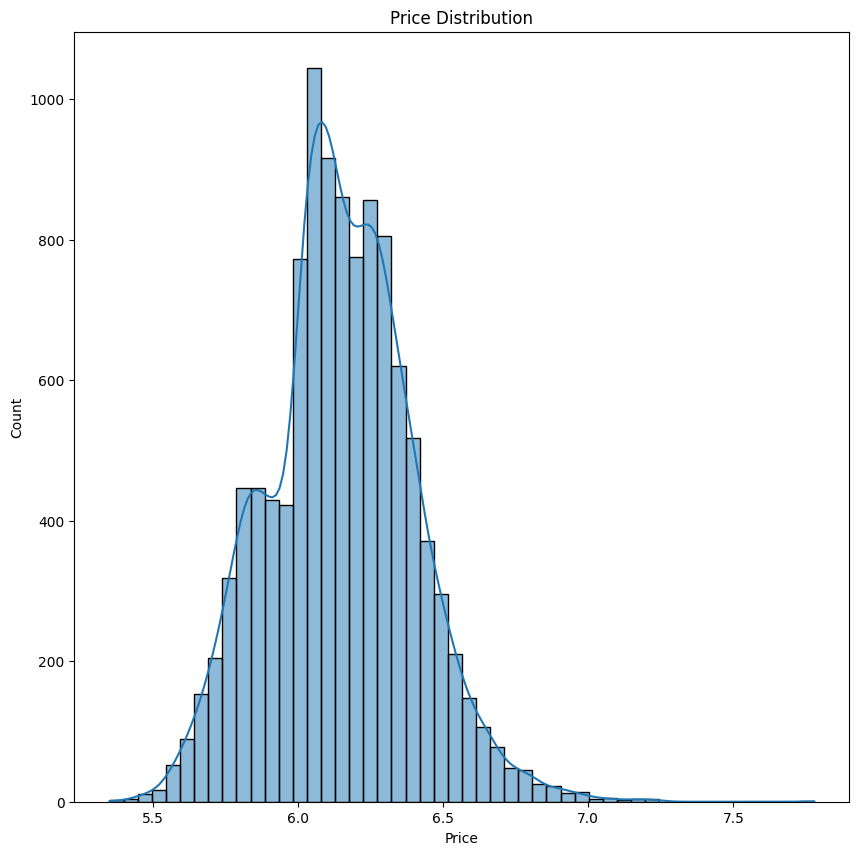

In [149]:
plt.figure(figsize=(10,10))
sns.histplot(np.log10(Sydney_merged["price"]), bins=50, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

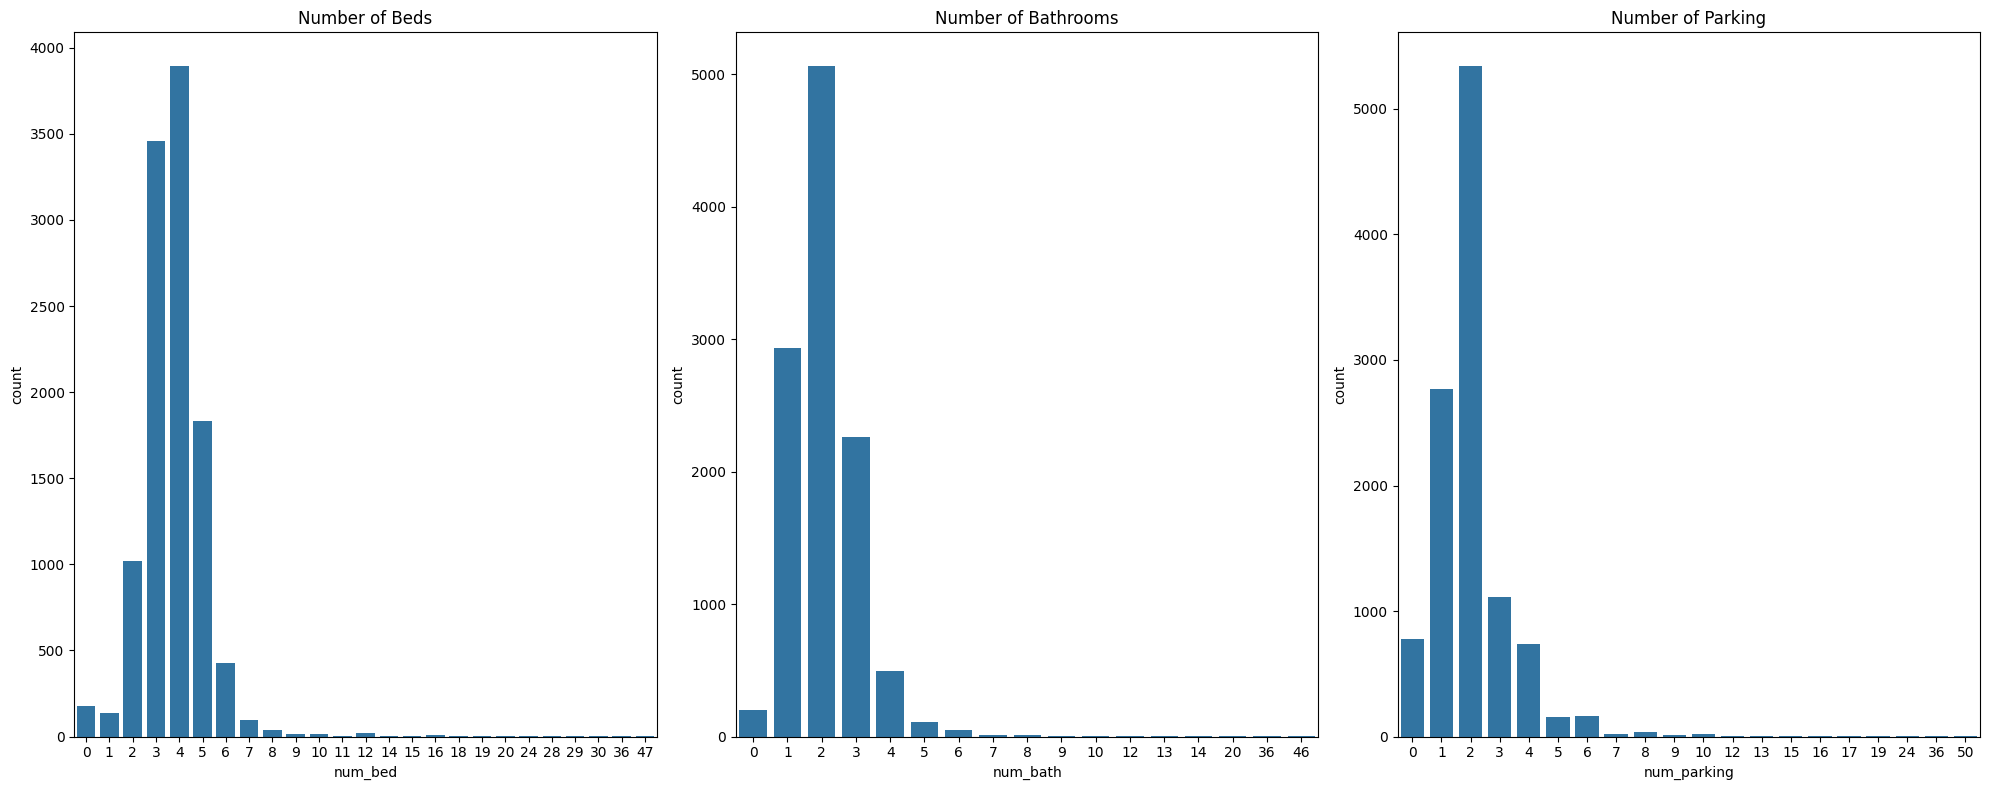

In [150]:
fig, axes = plt.subplots(1, 3, figsize=(20,8))
sns.countplot(x="num_bed", data=Sydney_merged, ax=axes[0])
axes[0].set_title("Number of Beds")

sns.countplot(x="num_bath", data=Sydney_merged, ax=axes[1])
axes[1].set_title("Number of Bathrooms")

sns.countplot(x="num_parking", data=Sydney_merged, ax=axes[2])
axes[2].set_title("Number of Parking")

plt.tight_layout()
plt.show()

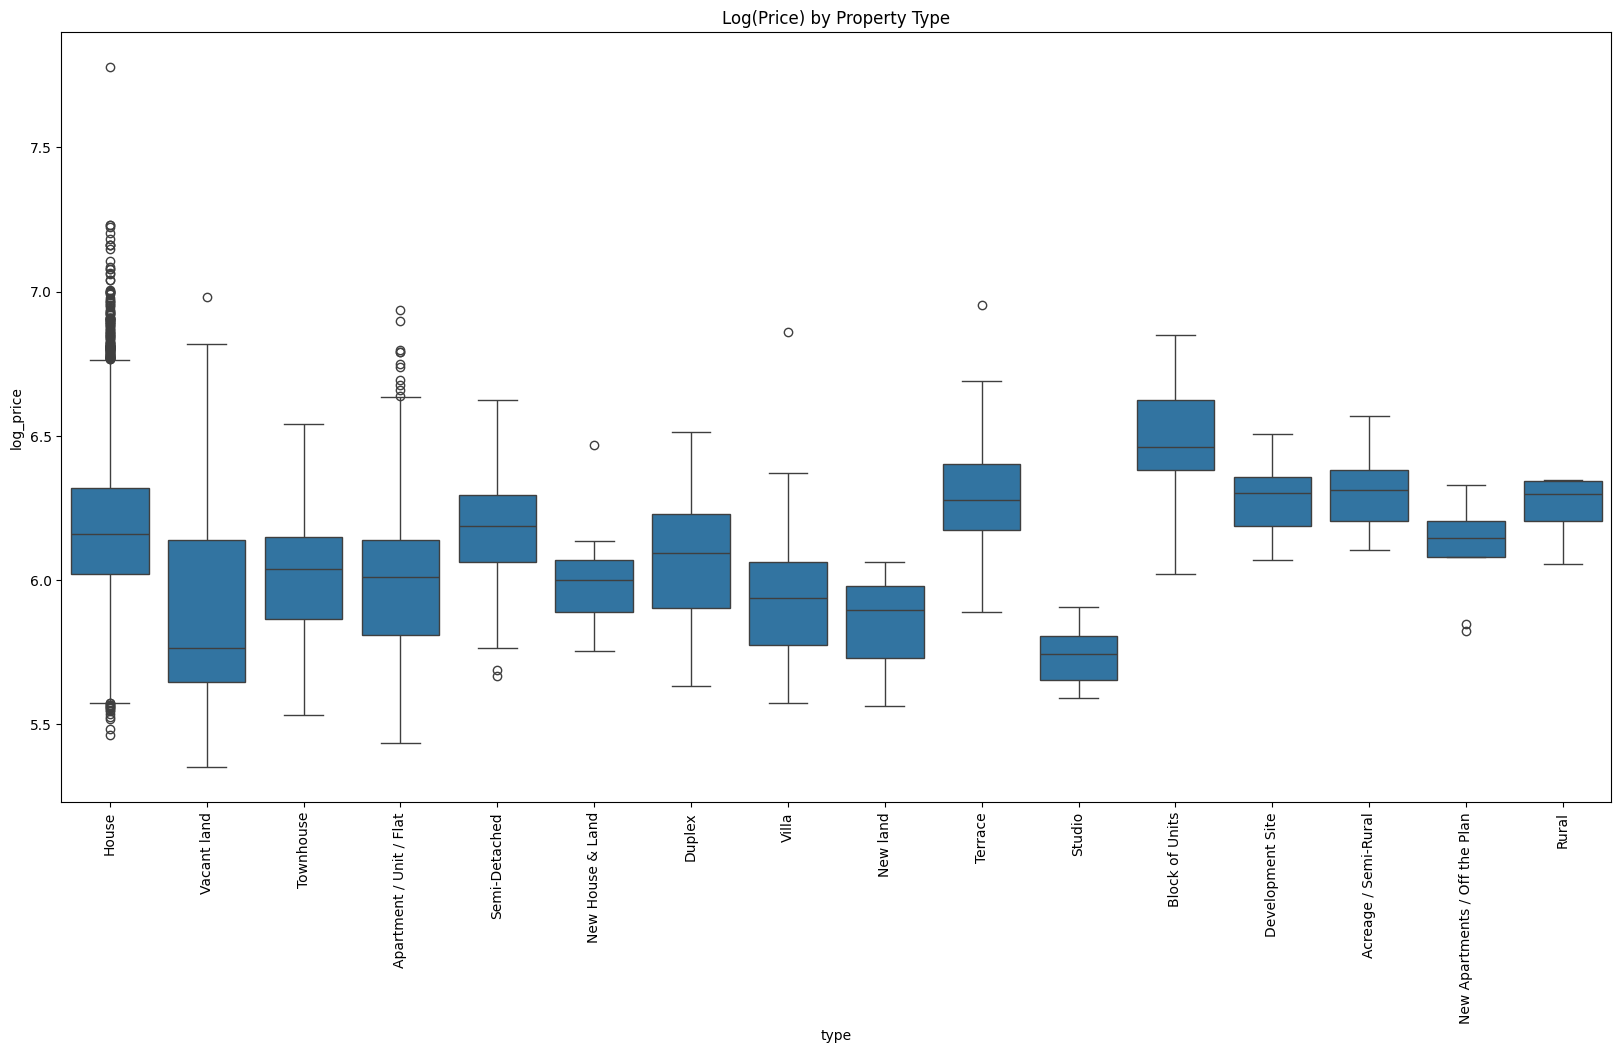

In [151]:
# Log-transform price (visualisation only)
Sydney_merged["log_price"] = np.log10(Sydney_merged["price"])

plt.figure(figsize=(20, 10))
sns.boxplot(x="type", y="log_price", data=Sydney_merged)
plt.xticks(rotation=90)
plt.title("Log(Price) by Property Type")
plt.show()

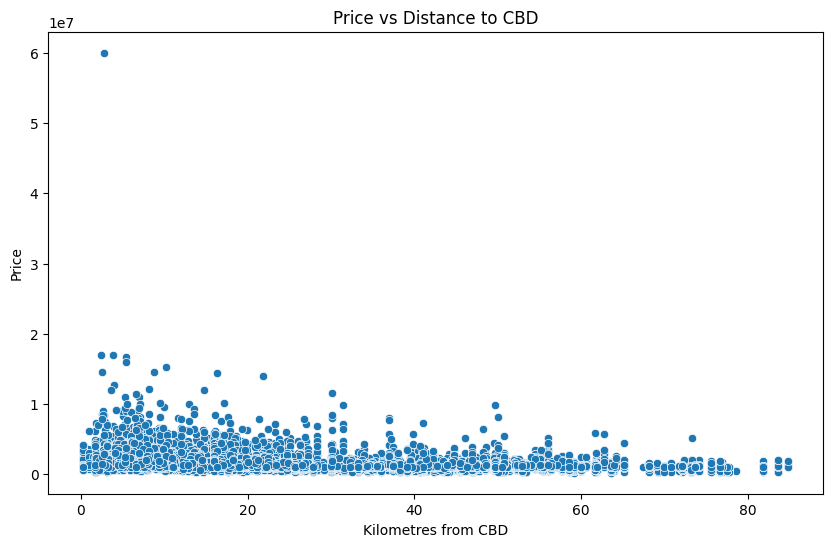

In [152]:
# Scatter: Price vs Distance to CBD
plt.figure(figsize=(10, 6))
sns.scatterplot(x="km_from_cbd", y="price", data=Sydney_merged)
plt.title("Price vs Distance to CBD")
plt.xlabel("Kilometres from CBD")
plt.ylabel("Price")
plt.show()

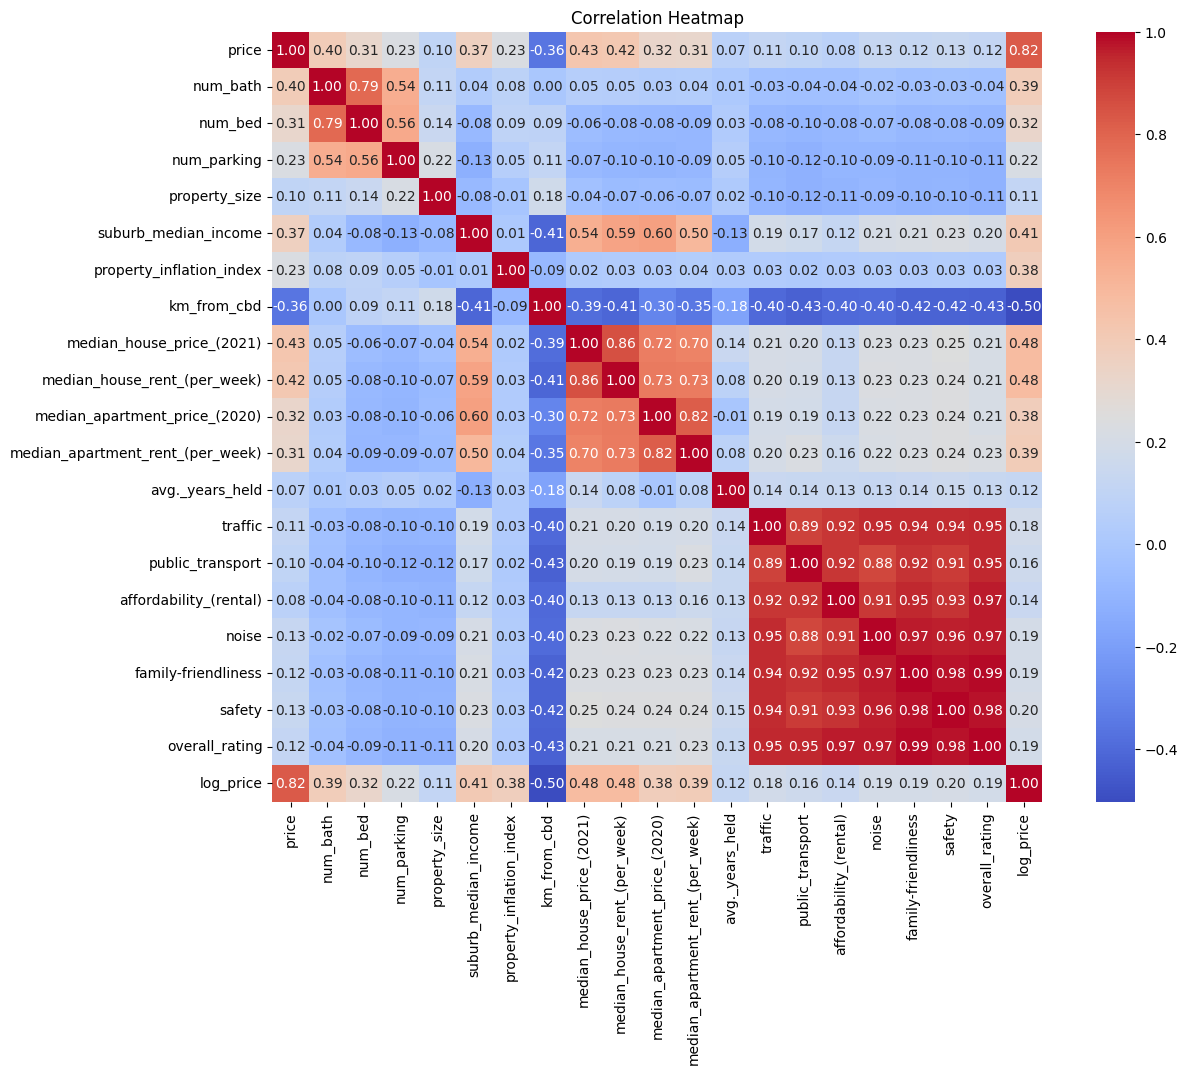

In [153]:
plt.figure(figsize=(14,10))
sns.heatmap(Sydney_merged.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()

In [154]:
Sydney_merged.drop(columns=["log_price"], inplace=True, errors="ignore")

Sydney_encoded = pd.get_dummies(Sydney_merged, columns=["type"], drop_first=True)
Sydney_encoded.columns

Index(['price', 'date_sold', 'suburb', 'num_bath', 'num_bed', 'num_parking',
       'property_size', 'suburb_median_income', 'property_inflation_index',
       'km_from_cbd', 'median_house_price_(2021)',
       'median_house_rent_(per_week)', 'median_apartment_price_(2020)',
       'median_apartment_rent_(per_week)', 'public_housing_%',
       'avg._years_held', 'time_to_cbd_(public_transport)_[town_hall_st]',
       'time_to_cbd_(driving)_[town_hall_st]', 'traffic', 'public_transport',
       'affordability_(rental)', 'noise', 'family-friendliness', 'safety',
       'overall_rating', 'type_Apartment / Unit / Flat', 'type_Block of Units',
       'type_Development Site', 'type_Duplex', 'type_House',
       'type_New Apartments / Off the Plan', 'type_New House & Land',
       'type_New land', 'type_Rural', 'type_Semi-Detached', 'type_Studio',
       'type_Terrace', 'type_Townhouse', 'type_Vacant land', 'type_Villa'],
      dtype='object')

In [155]:
X = Sydney_encoded.drop(columns=["price"])
y = Sydney_encoded["price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
Sydney_encoded.dtypes

price                                                     int64
date_sold                                        datetime64[ns]
suburb                                                   object
num_bath                                                  int64
num_bed                                                   int64
num_parking                                               int64
property_size                                             int64
suburb_median_income                                      int64
property_inflation_index                                float64
km_from_cbd                                             float64
median_house_price_(2021)                               float64
median_house_rent_(per_week)                            float64
median_apartment_price_(2020)                           float64
median_apartment_rent_(per_week)                        float64
public_housing_%                                         object
avg._years_held                         

In [156]:
X_train = X_train.drop(columns=["suburb", "date_sold"], errors="ignore")
X_test = X_test.drop(columns=["suburb", "date_sold"], errors="ignore")

cols_to_float = [
    "public_housing_%",
    "time_to_cbd_(public_transport)_[town_hall_st]", "time_to_cbd_(driving)_[town_hall_st]"
    ]

for col in cols_to_float:
    X_train[col] = pd.to_numeric(X_train[col], errors="coerce")
    X_test[col] = pd.to_numeric(X_test[col], errors="coerce")

bool_cols = Sydney_encoded.select_dtypes("bool").columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

In [157]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values